In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './double_pendulum_HNN'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 4,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './double_pendulum_HNN'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [3]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
#field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data = get_dataset()

def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    print(output_dim)
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)

    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/pend{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

In [4]:
def integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,4)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [5]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

# integrate along those fields starting from point (1,0)
t_span = [0,28]
y0 = np.asarray([1.57,1.57, 0, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

4
2


In [6]:
def integrate_models(x0=np.asarray([1.57, 1.57,0 ,0]), t_span=[0,25], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    return true_x, base_x, hnn_x


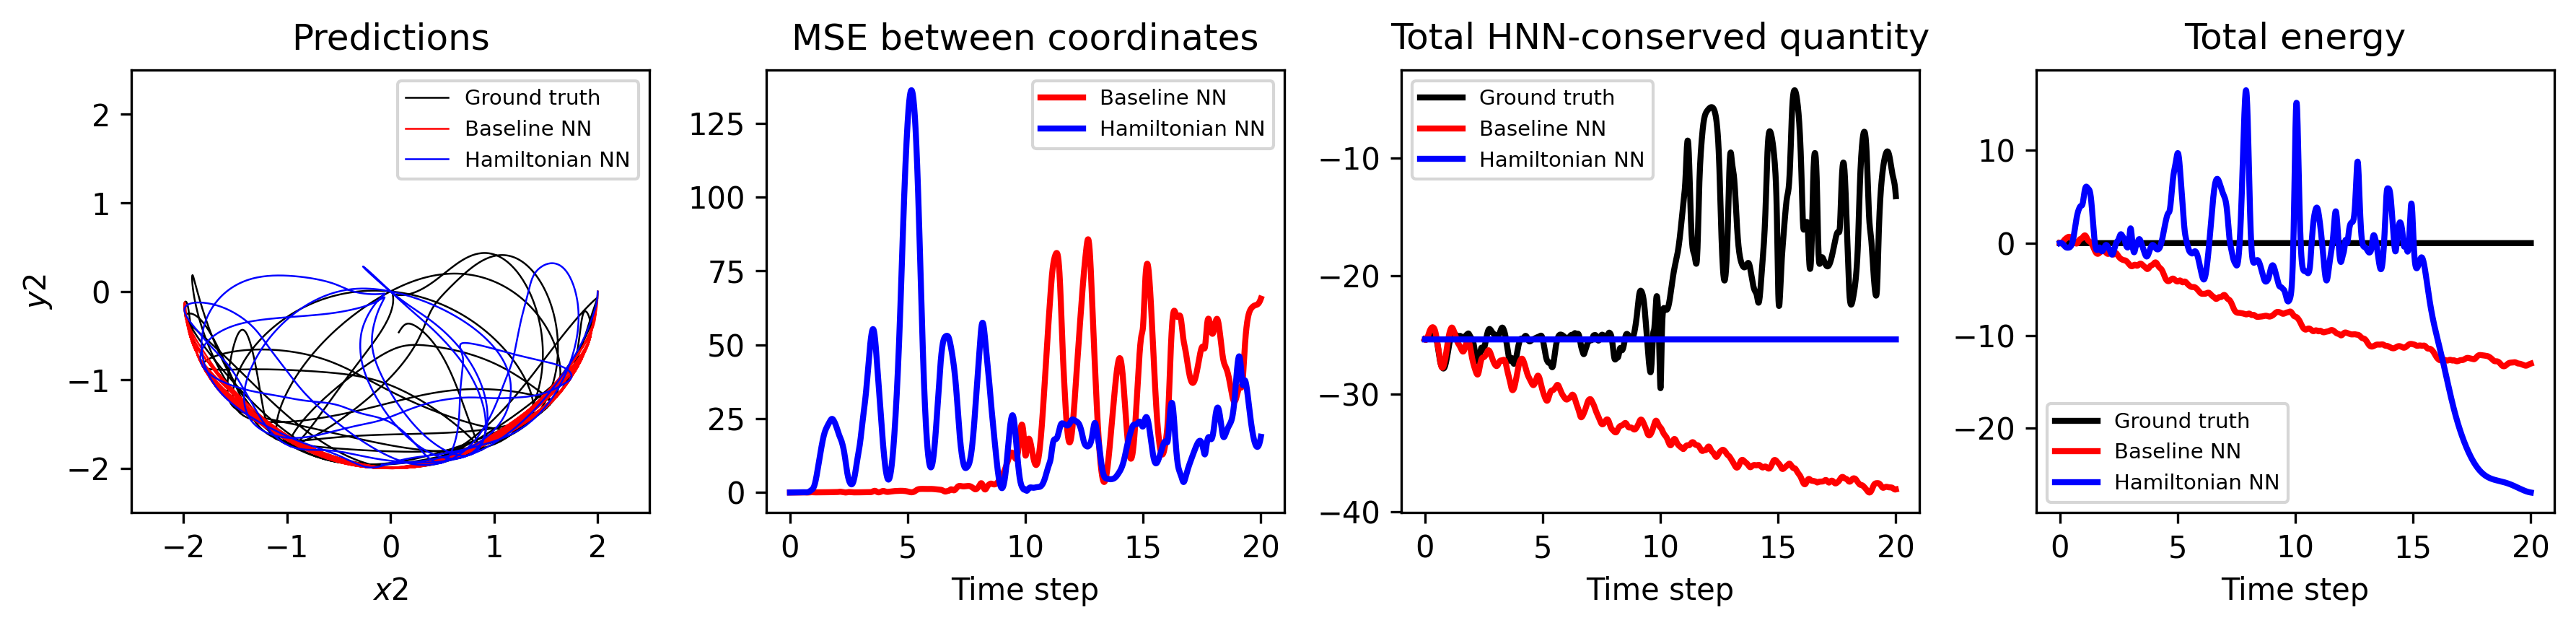

In [8]:
x0 = np.asarray([1.57, 1.57, 0, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$x2$') ; plt.ylabel('$y2$')
plt.plot(np.sin(true_x[:,0])+np.sin(true_x[:,1]), -np.cos(true_x[:,0])-np.cos(true_x[:,1]), 'k-', label='Ground truth', linewidth=0.6)
plt.plot(np.sin(base_x[:,0])+np.sin(base_x[:,1]), -np.cos(base_x[:,0])-np.cos(base_x[:,1]), 'r-', label='Baseline NN', linewidth=0.6)
plt.plot(np.sin(hnn_x[:,0])+np.sin(hnn_x[:,1]), -np.cos(hnn_x[:,0])-np.cos(hnn_x[:,1]), 'b-', label='Hamiltonian NN', linewidth=0.6)
plt.xlim(-2.5,2.5) ; plt.ylim(-2.5,2.5)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('pend-integration{}.{}'.format(RK4, FORMAT))